In [4]:
# Import required libraries.
from sportsipy.nfl.boxscore import Boxscores, Boxscore
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas

pd.set_option('display.max_columns', None)

## Add Display & Get_Schedule Function for use in model outputs

In [5]:
def get_schedule(year):
    weeks = list(range(1,18))
    schedule_df = pd.DataFrame()
    for w in range(len(weeks)):
        date_string = str(weeks[w]) + '-' + str(year)
        week_scores = Boxscores(weeks[w],year)
        week_games_df = pd.DataFrame()
        for g in range(len(week_scores.games[date_string])):
            game = pd.DataFrame(week_scores.games[date_string][g], index = [0])[['away_name', 'away_abbr','home_name', 'home_abbr','winning_name', 'winning_abbr' ]]
            game['week'] = weeks[w]
            week_games_df = pd.concat([week_games_df,game])
        schedule_df = pd.concat([schedule_df, week_games_df]).reset_index().drop(columns = 'index') 
    return schedule_df

def display(y_pred,X_test):
    for g in range(len(y_pred)):
        #win_prob = np.round(y_pred[g],2)
        win_prob = int(y_pred[g] * 100)
        away_team = X_test.reset_index().drop(columns = 'index').loc[g,'away_name']
        home_team = X_test.reset_index().drop(columns = 'index').loc[g,'home_name']
        print(f'The {away_team} have a probability of {win_prob}% of beating the {home_team}.')

## Read in Dataset from csv

In [8]:
df = pd.read_csv('2021_week_2_through_14.csv')

# Preview dataset
df.tail()

,away_name,away_abbr,home_name,home_abbr,week,win_perc_dif,first_downs_dif,fumbles_dif,interceptions_dif,net_pass_yards_dif,pass_attempts_dif,pass_completions_dif,pass_touchdowns_dif,pass_yards_dif,penalties_dif,points_dif,rush_attempts_dif,rush_touchdowns_dif,rush_yards_dif,time_of_possession_dif,times_sacked_dif,total_yards_dif,turnovers_dif,yards_from_penalties_dif,yards_lost_from_sacks_dif,fourth_down_perc_dif,third_down_perc_dif,result,elo_dif,qb_dif
186,New York Giants,nyg,Los Angeles Chargers,sdg,14,-0.250000,-4.000000,0.666667,-0.083333,-60.083333,-3.333333,-3.500000,-1.333333,-58.416667,-1.500000,-8.583333,0.583333,-0.333333,-10.166667,-1.250000,0.083333,-70.250000,0.000000,-16.500000,1.666667,-0.119048,-0.080808,0.0,-110.229362,-126.445654
187,Detroit Lions,det,Denver Broncos,den,14,-0.409091,-0.916667,0.416667,0.000000,-24.833333,1.416667,0.916667,-0.250000,-20.333333,1.500000,-2.833333,-1.666667,0.000000,-8.166667,-165.000000,-0.083333,-33.000000,0.083333,9.333333,4.500000,-0.195971,-0.052985,0.0,-173.770079,-0.964572
188,Buffalo Bills,buf,Tampa Bay Buccaneers,tam,14,-0.166667,-2.000000,0.750000,0.083333,-51.750000,-5.750000,-5.000000,-0.666667,-49.500000,0.333333,-3.416667,3.916667,0.000000,24.083333,26.583333,0.333333,-27.666667,0.083333,-0.416667,2.250000,-0.250000,0.003930,0.0,-44.281063,-16.339024
189,Chicago Bears,chi,Green Bay Packers,gnb,14,-0.416667,-2.166667,0.166667,0.750000,-74.583333,-5.250000,-4.833333,-1.166667,-63.166667,1.750000,-6.833333,2.333333,0.166667,18.416667,-189.166667,1.416667,-56.166667,0.750000,10.250000,11.416667,-0.088235,-0.075342,0.0,-239.644166,-177.084461
190,Los Angeles Rams,ram,Arizona Cardinals,crd,14,-0.166667,-0.250000,-1.250000,0.166667,44.416667,6.083333,1.833333,0.666667,38.833333,-1.416667,-0.583333,-6.833333,-0.916667,-26.250000,-176.250000,-0.750000,18.166667,0.250000,-14.083333,-5.583333,-0.200000,-0.026152,0.0,-61.165557,-20.046215


# Logistic Regression

### Logistic Regression Predictions

In [9]:
# Import Logistic Regression & Sklearn modules
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [90]:
# Set prediction week and split dataset workbook between prediction games and completed games.
pred_week = 14
comp_games_df = df[df['week'] < pred_week]
pred_games_df = df[df['week'] == pred_week]

In [91]:
# Rename train & test dataframes. Split features and results.
train_df = comp_games_df
test_df = pred_games_df

X_train = train_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
y_train = train_df[['result']] 
X_test = test_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
y_test = test_df[['result']]

In [12]:
# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Fit the scaler to the features training dataset
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [14]:
# Logistic Model
clf_unscaled = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight='balanced', random_state=None, 
                   solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)

clf_scaled = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.0, fit_intercept=True, 
                   intercept_scaling=1, class_weight='balanced', random_state=None, 
                   solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)

clf_unscaled.fit(X_train, np.ravel(y_train.values))
clf_scaled.fit(X_train_scaled, np.ravel(y_train.values))

y_pred_unscaled = clf_unscaled.predict_proba(X_test)
y_pred_scaled = clf_scaled.predict_proba(X_test_scaled)

y_pred_unscaled = y_pred_unscaled[:,1]
y_pred_scaled = y_pred_scaled[:,1]

print("Logistic Regression - Unscaled\n")
display(y_pred_unscaled,test_df)

print("\nLogistic Regression - Scaled\n")
display(y_pred_scaled,test_df)

Logistic Regression - Unscaled

The Pittsburgh Steelers have a probability of 53% of beating the Minnesota Vikings.
The San Francisco 49ers have a probability of 28% of beating the Cincinnati Bengals.
The Atlanta Falcons have a probability of 56% of beating the Carolina Panthers.
The Dallas Cowboys have a probability of 66% of beating the Washington Football Team.
The Jacksonville Jaguars have a probability of 17% of beating the Tennessee Titans.
The New Orleans Saints have a probability of 42% of beating the New York Jets.
The Las Vegas Raiders have a probability of 14% of beating the Kansas City Chiefs.
The Seattle Seahawks have a probability of 71% of beating the Houston Texans.
The Baltimore Ravens have a probability of 69% of beating the Cleveland Browns.
The New York Giants have a probability of 30% of beating the Los Angeles Chargers.
The Detroit Lions have a probability of 22% of beating the Denver Broncos.
The Buffalo Bills have a probability of 40% of beating the Tampa Bay Bu

### Get Logistic Regression Accuracy

In [15]:
# make a for loop to the get accuracy for each week
def accuracy_score_log_reg(df):
    
    accuracy = pd.DataFrame(
        columns=[
            'week', 
            'Logistic Regression Accuracy - Unscaled', 
            'Logistic Regeression Accuracy - Scaled',
            'Log Reg - Unscaled - drop 40% to 60%',
            'Log Reg - Scaled - drop 40% to 60%'
        ])
    
    for w in df['week'].unique()[1:-1]:
        train_df = df[df['week'] < w]
        test_df = df[df['week'] == w]
        
        X_train = train_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
        y_train = train_df[['result']] 
        X_test = test_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
        y_test = test_df[['result']]
        
        # Create a StandardScaler instance
        scaler = StandardScaler()

        # Fit the scaler to the features training dataset
        X_scaler = scaler.fit(X_train)

        # Fit the scaler to the features training dataset
        X_train_scaled = X_scaler.transform(X_train)
        X_test_scaled = X_scaler.transform(X_test)
        
        clf_unscaled = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight='balanced', random_state=None, 
                           solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)

        clf_scaled = LogisticRegression(penalty='l1', dual=False, tol=0.001, C=1.0, fit_intercept=True, 
                           intercept_scaling=1, class_weight='balanced', random_state=None, 
                           solver='liblinear', max_iter=1000, multi_class='ovr', verbose=0)

        clf_unscaled.fit(X_train, np.ravel(y_train.values))
        clf_scaled.fit(X_train_scaled, np.ravel(y_train.values))
        
        y_pred_unscaled = clf_unscaled.predict_proba(X_test)
        y_pred_scaled = clf_scaled.predict_proba(X_test_scaled)
        
        y_pred_unscaled = y_pred_unscaled[:,1]
        y_pred_scaled = y_pred_scaled[:,1]
        
        accuracy_score_unscaled = accuracy_score(y_test, np.round(y_pred_unscaled))
        accuracy_score_scaled = accuracy_score(y_test, np.round(y_pred_scaled))
        accuracy_score_unscaled_drop_40_60 = accuracy_score(y_test[(y_pred_unscaled < .4) | (y_pred_unscaled > .6)], np.round(y_pred_unscaled[(y_pred_unscaled < .4) | (y_pred_unscaled > .6)]))
        accuracy_score_scaled_drop_40_60 = accuracy_score(y_test[(y_pred_scaled < .4) | (y_pred_scaled > .6)],np.round(y_pred_scaled[(y_pred_scaled < .4) | (y_pred_scaled > .6)]))
        
        accuracy.loc[w,:] = [w, accuracy_score_unscaled, accuracy_score_scaled, accuracy_score_unscaled_drop_40_60, accuracy_score_scaled_drop_40_60]
        
    return(accuracy)

In [16]:
# Call the accuracy function and output the df.
logistic_regression_accuracy = accuracy_score_log_reg(df)
logistic_regression_accuracy

,week,Logistic Regression Accuracy - Unscaled,Logistic Regeression Accuracy - Scaled,Log Reg - Unscaled - drop 40% to 60%,Log Reg - Scaled - drop 40% to 60%
3,3,0.6,0.533333,0.571429,0.625
4,4,0.625,0.6875,0.666667,0.692308
5,5,0.5,0.625,0.466667,0.666667
6,6,0.857143,0.857143,0.846154,0.909091
7,7,0.769231,0.769231,0.75,0.8
8,8,0.466667,0.466667,0.5,0.466667
9,9,0.642857,0.714286,0.6,0.636364
10,10,0.5,0.5,0.5,0.538462
11,11,0.666667,0.6,0.777778,0.777778
12,12,0.733333,0.6,0.8,0.714286


# Tensorflow 

### Tensorflow Predictions

In [17]:
# import tensorflow libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split

In [18]:
# Set prediction week and split dataset workbook between prediction games and completed games.

pred_week = 14
comp_games_df = df[df['week'] < pred_week]
pred_games_df = df[df['week'] == pred_week]

In [19]:
# Rename train & test dataframes. Split features and results.
train_df = comp_games_df
test_df = pred_games_df

X_train = train_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
y_train = train_df[['result']] 
X_test = test_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
y_test = test_df[['result']]

In [30]:
# Preview train & test dataframes
X_train

,win_perc_dif,first_downs_dif,fumbles_dif,interceptions_dif,net_pass_yards_dif,pass_attempts_dif,pass_completions_dif,pass_touchdowns_dif,pass_yards_dif,penalties_dif,points_dif,rush_attempts_dif,rush_touchdowns_dif,rush_yards_dif,time_of_possession_dif,times_sacked_dif,total_yards_dif,turnovers_dif,yards_from_penalties_dif,yards_lost_from_sacks_dif,fourth_down_perc_dif,third_down_perc_dif,elo_dif,qb_dif
0,0.000000,4.000000,-2.000000,0.000000,121.000000,16.000000,8.000000,0.000000,132.000000,-5.000000,-3.000000,-7.000000,1.000000,-66.000000,55.000000,1.000000,55.000000,0.000000,-18.000000,11.000000,-0.666667,0.200000,-50.848658,100.316973
1,1.000000,-4.000000,-1.000000,-1.000000,29.000000,-13.000000,-9.000000,2.000000,45.000000,0.000000,13.000000,10.000000,-1.000000,15.000000,-23.000000,2.000000,44.000000,-2.000000,-20.000000,16.000000,0.666667,-0.240260,-51.742731,34.616025
2,0.000000,4.000000,-1.000000,0.000000,-119.000000,-14.000000,-9.000000,4.000000,-128.000000,0.000000,19.000000,12.000000,-1.000000,60.000000,196.000000,-1.000000,-59.000000,-1.000000,-2.000000,-9.000000,1.000000,0.214286,204.627654,54.983874
3,0.000000,10.000000,0.000000,1.000000,232.000000,24.000000,16.000000,1.000000,247.000000,5.000000,10.000000,0.000000,2.000000,7.000000,445.000000,1.000000,239.000000,1.000000,30.000000,15.000000,0.000000,0.133333,-62.282436,-14.386838
4,0.000000,-3.000000,0.000000,0.000000,50.000000,-9.000000,-9.000000,-1.000000,55.000000,-7.000000,9.000000,-3.000000,1.000000,-42.000000,-270.000000,0.000000,8.000000,2.000000,-10.000000,5.000000,0.000000,-0.128205,36.874709,-13.318243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,-0.090909,1.454545,0.272727,0.090909,-72.181818,-4.000000,-2.818182,-0.090909,-71.636364,-2.454545,-2.727273,5.818182,-0.181818,36.454545,81.818182,-0.090909,-35.727273,0.363636,-21.000000,0.545455,0.058462,0.048097,15.185078,-68.820114
173,-0.454545,-2.636364,0.727273,0.000000,-81.181818,-0.545455,-3.181818,-1.636364,-83.727273,2.272727,-11.454545,-0.727273,0.272727,19.909091,-60.545455,0.272727,-61.272727,0.454545,13.909091,-2.545455,0.121429,-0.065264,-285.686464,-102.890676
174,0.227273,4.909091,-0.090909,0.545455,4.363636,-4.272727,-2.545455,0.000000,9.636364,-0.636364,3.545455,9.090909,0.454545,63.636364,258.090909,1.090909,68.000000,0.272727,5.000000,5.272727,0.384615,-0.060289,107.685364,27.419825
175,-0.090909,-5.454545,-1.000000,-0.363636,-66.727273,-9.000000,-5.181818,-0.909091,-58.272727,-1.272727,-4.818182,0.909091,0.090909,2.818182,32.272727,1.000000,-63.909091,-0.909091,-9.000000,8.454545,0.030303,-0.138340,-173.767258,-78.641705


## Fit and build the tensorflow model

In [20]:
# Define the the number of inputs (features) to the model
number_input_features = X_train.shape[1]

# Define the number of neurons in the output layer
number_output_neurons = 1

# Define the number of hidden nodes for three layer
hidden_nodes_layer1 =  (number_input_features + 1) // 2
hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) // 2
hidden_nodes_layer3 = (hidden_nodes_layer2 + 1) // 2

# Create the Sequential model instance
nn = Sequential()

# Add the hidden layers
nn.add(Dense(units=hidden_nodes_layer1, activation='relu', input_dim=number_input_features))
nn.add(Dense(units=hidden_nodes_layer2, activation='relu'))
nn.add(Dense(units=hidden_nodes_layer3, activation='relu'))

# Add the output layer to the model specifying the number of output neurons and activation function
nn.add(Dense(units=number_output_neurons, activation='sigmoid'))

# Display the Sequential model summary
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12)                300       
                                                                 
 dense_1 (Dense)             (None, 6)                 78        
                                                                 
 dense_2 (Dense)             (None, 3)                 21        
                                                                 
 dense_3 (Dense)             (None, 1)                 4         
                                                                 
Total params: 403
Trainable params: 403
Non-trainable params: 0
_________________________________________________________________


In [21]:
# Compile the Sequential model
nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Fit the model using 50 epochs and the training data
fit_model = nn.fit(X_train, y_train, epochs=500, verbose=0)

### Export the tensorflow model

In [22]:
# Set the model's file path
#file_path = "Resources/model_nn_2021_2_12_not_scaled_relu_relu_sigmoid_loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']_1000 epochs.h5"
file_path = "Resources/model_nn_2021_weeks_2_through_13.h5"

# Export your model to a HDF5 file
nn.save(file_path)

### Import the tensorflow model

In [23]:
# load a previously built model.
#file_path = "Resources/model_nn_relu_relu_sigmoid_loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']_200 epochs.h5"
#file_path = "Resources/model_nn_relu_relu_sigmoid_loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']_200 epochs.h5"

nn = tf.keras.models.load_model(file_path)

In [24]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data        
nn_predictions_unscaled = nn.predict(X_test)       

print("Tensorflow - Unscaled \n")
display(nn_predictions_unscaled.squeeze(),test_df)

Tensorflow - Unscaled 

The Pittsburgh Steelers have a probability of 97% of beating the Minnesota Vikings.
The San Francisco 49ers have a probability of 99% of beating the Cincinnati Bengals.
The Atlanta Falcons have a probability of 83% of beating the Carolina Panthers.
The Dallas Cowboys have a probability of 70% of beating the Washington Football Team.
The Jacksonville Jaguars have a probability of 4% of beating the Tennessee Titans.
The New Orleans Saints have a probability of 21% of beating the New York Jets.
The Las Vegas Raiders have a probability of 4% of beating the Kansas City Chiefs.
The Seattle Seahawks have a probability of 63% of beating the Houston Texans.
The Baltimore Ravens have a probability of 63% of beating the Cleveland Browns.
The New York Giants have a probability of 92% of beating the Los Angeles Chargers.
The Detroit Lions have a probability of 9% of beating the Denver Broncos.
The Buffalo Bills have a probability of 24% of beating the Tampa Bay Buccaneers.
T

## Tensorflow Accuracy

In [31]:
# Make a for loop to the get accuracy for each week of the NN Model.
def accuracy_score_tensorflow(df):
    
    accuracy = pd.DataFrame(columns=['week', 'Tensorflow Accuracy - Unscaled'])
    
    for w in df['week'].unique()[1:-1]:
        train_df = df[df['week'] < w]
        test_df = df[df['week'] == w]
        
        X_train = train_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
        y_train = train_df[['result']] 
        X_test = test_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
        y_test = test_df[['result']]
        
        # Build the model
        # Define the the number of inputs (features) to the model
        number_input_features = X_train.shape[1]

        # Define the number of neurons in the output layer
        number_output_neurons = 1

        # Define the number of hidden nodes for three layer
        hidden_nodes_layer1 =  (number_input_features + 1) // 2
        hidden_nodes_layer2 = (hidden_nodes_layer1 + 1) // 2
        hidden_nodes_layer3 = (hidden_nodes_layer2 + 1) // 2

        # Create the Sequential model instance
        nn = Sequential()

        # Add the hidden layers
        nn.add(Dense(units=hidden_nodes_layer1, activation='relu', input_dim=number_input_features))
        nn.add(Dense(units=hidden_nodes_layer2, activation='relu'))
        nn.add(Dense(units=hidden_nodes_layer3, activation='relu'))

        # Add the output layer to the model specifying the number of output neurons and activation function
        nn.add(Dense(units=number_output_neurons, activation='sigmoid'))
        
        # Fit the model
        # Compile the Sequential model
        nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Fit the model using 500 epochs and the training data
        nn.fit(X_train, y_train, epochs=500, verbose=0)
        
        # Evaluate the model loss and accuracy metrics using the evaluate method and the test data        
        model_accuracy_unscaled = nn.evaluate(X_test, y_test, verbose=0)       
    
        # Assign the accuracy to 
        accuracy.loc[w,:] = [w, model_accuracy_unscaled[1]]
        
    return(accuracy)

In [32]:
# Run the accuracy_score_Tensorflow function to get an array of accuracies
tensorflow_accuracy = accuracy_score_tensorflow(df)
tensorflow_accuracy

,week,Tensorflow Accuracy - Unscaled
3,3,0.466667
4,4,0.5
5,5,0.6875
6,6,0.785714
7,7,0.692308
8,8,0.666667
9,9,0.714286
10,10,0.714286
11,11,0.6
12,12,0.466667


In [34]:
accuracy_df = pd.concat(
    [logistic_regression_accuracy, tensorflow_accuracy.drop(columns=['week'])], axis=1)
accuracy_df

,week,Logistic Regression Accuracy - Unscaled,Logistic Regeression Accuracy - Scaled,Log Reg - Unscaled - drop 40% to 60%,Log Reg - Scaled - drop 40% to 60%,Tensorflow Accuracy - Unscaled
3,3,0.6,0.533333,0.571429,0.625,0.466667
4,4,0.625,0.6875,0.666667,0.692308,0.5
5,5,0.5,0.625,0.466667,0.666667,0.6875
6,6,0.857143,0.857143,0.846154,0.909091,0.785714
7,7,0.769231,0.769231,0.75,0.8,0.692308
8,8,0.466667,0.466667,0.5,0.466667,0.666667
9,9,0.642857,0.714286,0.6,0.636364,0.714286
10,10,0.5,0.5,0.5,0.538462,0.714286
11,11,0.666667,0.6,0.777778,0.777778,0.6
12,12,0.733333,0.6,0.8,0.714286,0.466667


# Random Forest Model

In [35]:
# Set prediction week and split dataframe into completed & prediction games.
pred_week = 14
comp_games_df = df[df['week'] < pred_week]
pred_games_df = df[df['week'] == pred_week]

In [36]:
# Label train & test dataframes. Split X & y (features & results).

train_df = comp_games_df
test_df = pred_games_df

X_train = train_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
y_train = train_df[['result']] 
X_test = test_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
y_test = test_df[['result']]

In [37]:
# Create a random forest classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

# Fitting the model
rf_fitted = rf_model.fit(X_train, np.ravel(y_train.values))

# Making predictions using the testing data
y_pred = rf_fitted.predict_proba(X_test)
y_pred = y_pred[:,1]
y = rf_fitted.predict(X_test)

# print("RandomForest - Unscaled \n")
display(y_pred, test_df)

The Pittsburgh Steelers have a probability of 44% of beating the Minnesota Vikings.
The San Francisco 49ers have a probability of 41% of beating the Cincinnati Bengals.
The Atlanta Falcons have a probability of 77% of beating the Carolina Panthers.
The Dallas Cowboys have a probability of 63% of beating the Washington Football Team.
The Jacksonville Jaguars have a probability of 32% of beating the Tennessee Titans.
The New Orleans Saints have a probability of 54% of beating the New York Jets.
The Las Vegas Raiders have a probability of 22% of beating the Kansas City Chiefs.
The Seattle Seahawks have a probability of 57% of beating the Houston Texans.
The Baltimore Ravens have a probability of 85% of beating the Cleveland Browns.
The New York Giants have a probability of 23% of beating the Los Angeles Chargers.
The Detroit Lions have a probability of 21% of beating the Denver Broncos.
The Buffalo Bills have a probability of 60% of beating the Tampa Bay Buccaneers.
The Chicago Bears have

### Random Forest Feature Importance

In [38]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_

important_features = zip(X_test.columns,rf_model.feature_importances_)

important_features

In [39]:
# Create a dataframe of the important features
importances_df = pd.DataFrame(important_features)

# Rename the columns
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

# Set the index
importances_df = importances_df.set_index('Feature')

# Sort the dataframe by feature importance
importances_df = importances_df.sort_values(by='Importance',ascending=False)

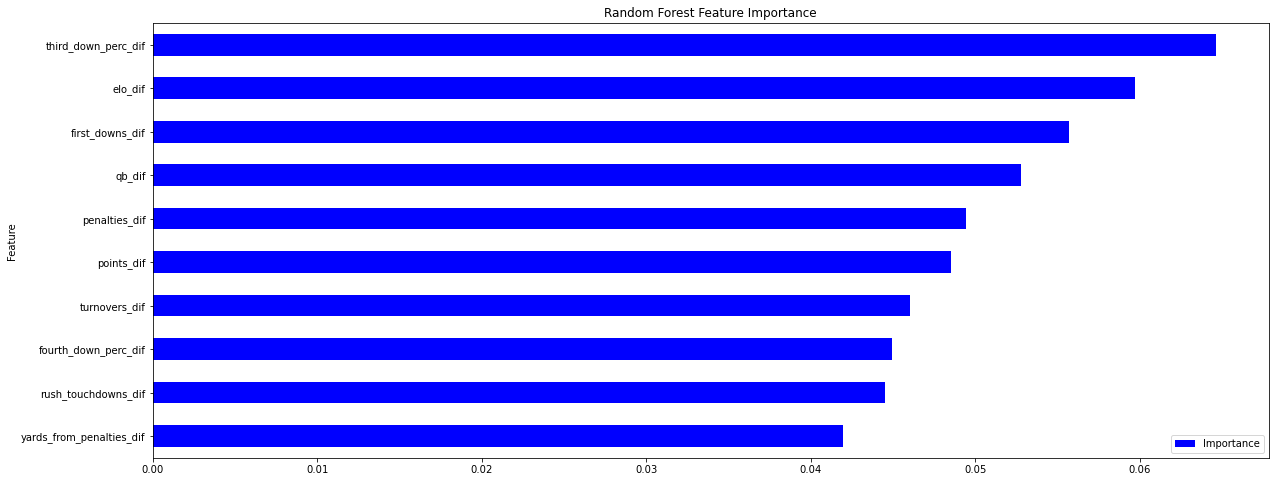

In [27]:
# Plot the top 10 most important features
importances_df[0:10].sort_values('Importance', ascending=True).plot(
    kind='barh', 
    color='blue', 
    title= 'Random Forest Feature Importance', 
    figsize=[20, 8],
    legend=True)

plt.savefig('Resources\RF_Feature_Importance_Week_14.png')

In [40]:
# Make a for loop to get the accuracy for each week of the random forest model.
def accuracy_score_random_forest(df):
    
    accuracy = pd.DataFrame(columns=['week', 'Random Forest Accuracy', 'Random Forest - drop 40% - 60%'])
    
    for w in df['week'].unique()[1:-1]:
        train_df = df[df['week'] < w]
        test_df = df[df['week'] == w]
        
        X_train = train_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
        y_train = train_df[['result']] 
        X_test = test_df.drop(columns = ['away_name', 'away_abbr', 'home_name', 'home_abbr', 'week','result'])
        y_test = test_df[['result']]
        
        # Fitting the model
        classifier = RandomForestClassifier(n_estimators=100, random_state=1)
        classifier.fit(X_train, np.ravel(y_train.values))
        y_pred = classifier.predict(X_test)
        y_pred_percent =  classifier.predict_proba(X_test)[:,1]
        
        model_accuracy = accuracy_score(y_test, y_pred)
        model_accuracy_drop_40_60 = accuracy_score(y_test[(y_pred_percent < .4) | (y_pred_percent > .6)], y_pred[(y_pred_percent < .4) | (y_pred_percent > .6)])

        # Assign the accuracy to 
        accuracy.loc[w,:] = [w, model_accuracy, model_accuracy_drop_40_60]
        
    return(accuracy)

In [41]:
random_forest_accuracy = accuracy_score_random_forest(df)
random_forest_accuracy

,week,Random Forest Accuracy,Random Forest - drop 40% - 60%
3,3,0.6,0.75
4,4,0.625,0.666667
5,5,0.625,0.8
6,6,0.785714,0.833333
7,7,0.846154,0.8
8,8,0.6,0.583333
9,9,0.642857,0.6
10,10,0.5,0.555556
11,11,0.8,0.7
12,12,0.466667,0.636364


In [42]:
accuracy_df = pd.concat(
    [logistic_regression_accuracy, 
     tensorflow_accuracy.drop(columns=['week']),
     random_forest_accuracy.drop(columns=['week'])], 
    axis=1)

accuracy_df

,week,Logistic Regression Accuracy - Unscaled,Logistic Regeression Accuracy - Scaled,Log Reg - Unscaled - drop 40% to 60%,Log Reg - Scaled - drop 40% to 60%,Tensorflow Accuracy - Unscaled,Random Forest Accuracy,Random Forest - drop 40% - 60%
3,3,0.6,0.533333,0.571429,0.625,0.466667,0.6,0.75
4,4,0.625,0.6875,0.666667,0.692308,0.5,0.625,0.666667
5,5,0.5,0.625,0.466667,0.666667,0.6875,0.625,0.8
6,6,0.857143,0.857143,0.846154,0.909091,0.785714,0.785714,0.833333
7,7,0.769231,0.769231,0.75,0.8,0.692308,0.846154,0.8
8,8,0.466667,0.466667,0.5,0.466667,0.666667,0.6,0.583333
9,9,0.642857,0.714286,0.6,0.636364,0.714286,0.642857,0.6
10,10,0.5,0.5,0.5,0.538462,0.714286,0.5,0.555556
11,11,0.666667,0.6,0.777778,0.777778,0.6,0.8,0.7
12,12,0.733333,0.6,0.8,0.714286,0.466667,0.466667,0.636364


In [43]:
accuracy_df.to_csv('Resources/accuracy_df.csv')

## Model Plots

In [60]:
# Plot accuracy of all models without dropping any predictions.
plot1 = accuracy_df.drop(columns=['Log Reg - Unscaled - drop 40% to 60%','Log Reg - Scaled - drop 40% to 60%','Random Forest - drop 40% - 60%'])
plot1.hvplot(
    x='week',
    frame_height=400,
    frame_width=1000,
    grid=True,
    xlabel='Week',
    ylabel='Correct Prediction %',
    yformatter='%.2f',
    title='Model Accuracy Comparison by Week')


:NdOverlay   [Variable]
   :Curve   [week]   (value)

In [66]:
# Plot accuracy of all models with "close" gams dropped (60% or less confidence games)
plot2 = accuracy_df[['week','Log Reg - Unscaled - drop 40% to 60%','Log Reg - Scaled - drop 40% to 60%','Random Forest - drop 40% - 60%']]
plot2.hvplot(
    x='week',
    frame_height=400,
    frame_width=1000,
    grid=True,
    xlabel='Week',
    ylabel='Correct Prediction %',
    yformatter='%.2f',
    title='Model Accuracy Comparison by Week - Dropped < 60% confident games')


:NdOverlay   [Variable]
   :Curve   [week]   (value)

In [88]:
# Plot all model iterations average over the season thus far.
plot3 = accuracy_df.mean(axis=0)
plot3 = plot3.drop(index='week')
y_lim=list([0,1.0])
plot3.hvplot.bar(
    invert=True,
    grid=True,
    ylim=y_lim,
    title='All Model Predictions - Average Accuracy up to Week 13',
    frame_width=700)


:Bars   [index]   (0)

In [89]:
# Tableau interactive chart showing all weekly model accuracy. 
# Currently broken

%%HTML
<div class='tableauPlaceholder' id='viz1638998595666' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;NF&#47;NFLPredictionModelAccuracy&#47;NFLPredictionModelAccuracy&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='site_root' value='' /><param name='name' value='NFLPredictionModelAccuracy&#47;NFLPredictionModelAccuracy' /><param name='tabs' value='yes' /><param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;NF&#47;NFLPredictionModelAccuracy&#47;NFLPredictionModelAccuracy&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /><param name='filter' value='publish=yes' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1638998595666');                    var vizElement = divElement.getElementsByTagName('object')[0];                    if ( divElement.offsetWidth > 800 ) { vizElement.style.minWidth='800px';vizElement.style.maxWidth='100%';vizElement.style.minHeight='1250px';vizElement.style.maxHeight=(divElement.offsetWidth*0.75)+'px';} else if ( divElement.offsetWidth > 500 ) { vizElement.style.minWidth='800px';vizElement.style.maxWidth='100%';vizElement.style.minHeight='1250px';vizElement.style.maxHeight=(divElement.offsetWidth*0.75)+'px';} else { vizElement.style.width='100%';vizElement.style.minHeight='800px';vizElement.style.maxHeight=(divElement.offsetWidth*1.77)+'px';}                     var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

SyntaxError: invalid syntax (<ipython-input-89-6920a75e6989>, line 4)